In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [3]:
data = pd.read_excel('anxiety-assesment-dataset.xlsx')
data.head()

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0


In [4]:

print(data.shape)

(6982, 2)


In [5]:

data.isnull().sum()

text     10
label     2
dtype: int64

In [6]:

data=data.dropna(how='any')

In [7]:

data['label'].value_counts()

label
0.0    6240
1.0     730
Name: count, dtype: int64

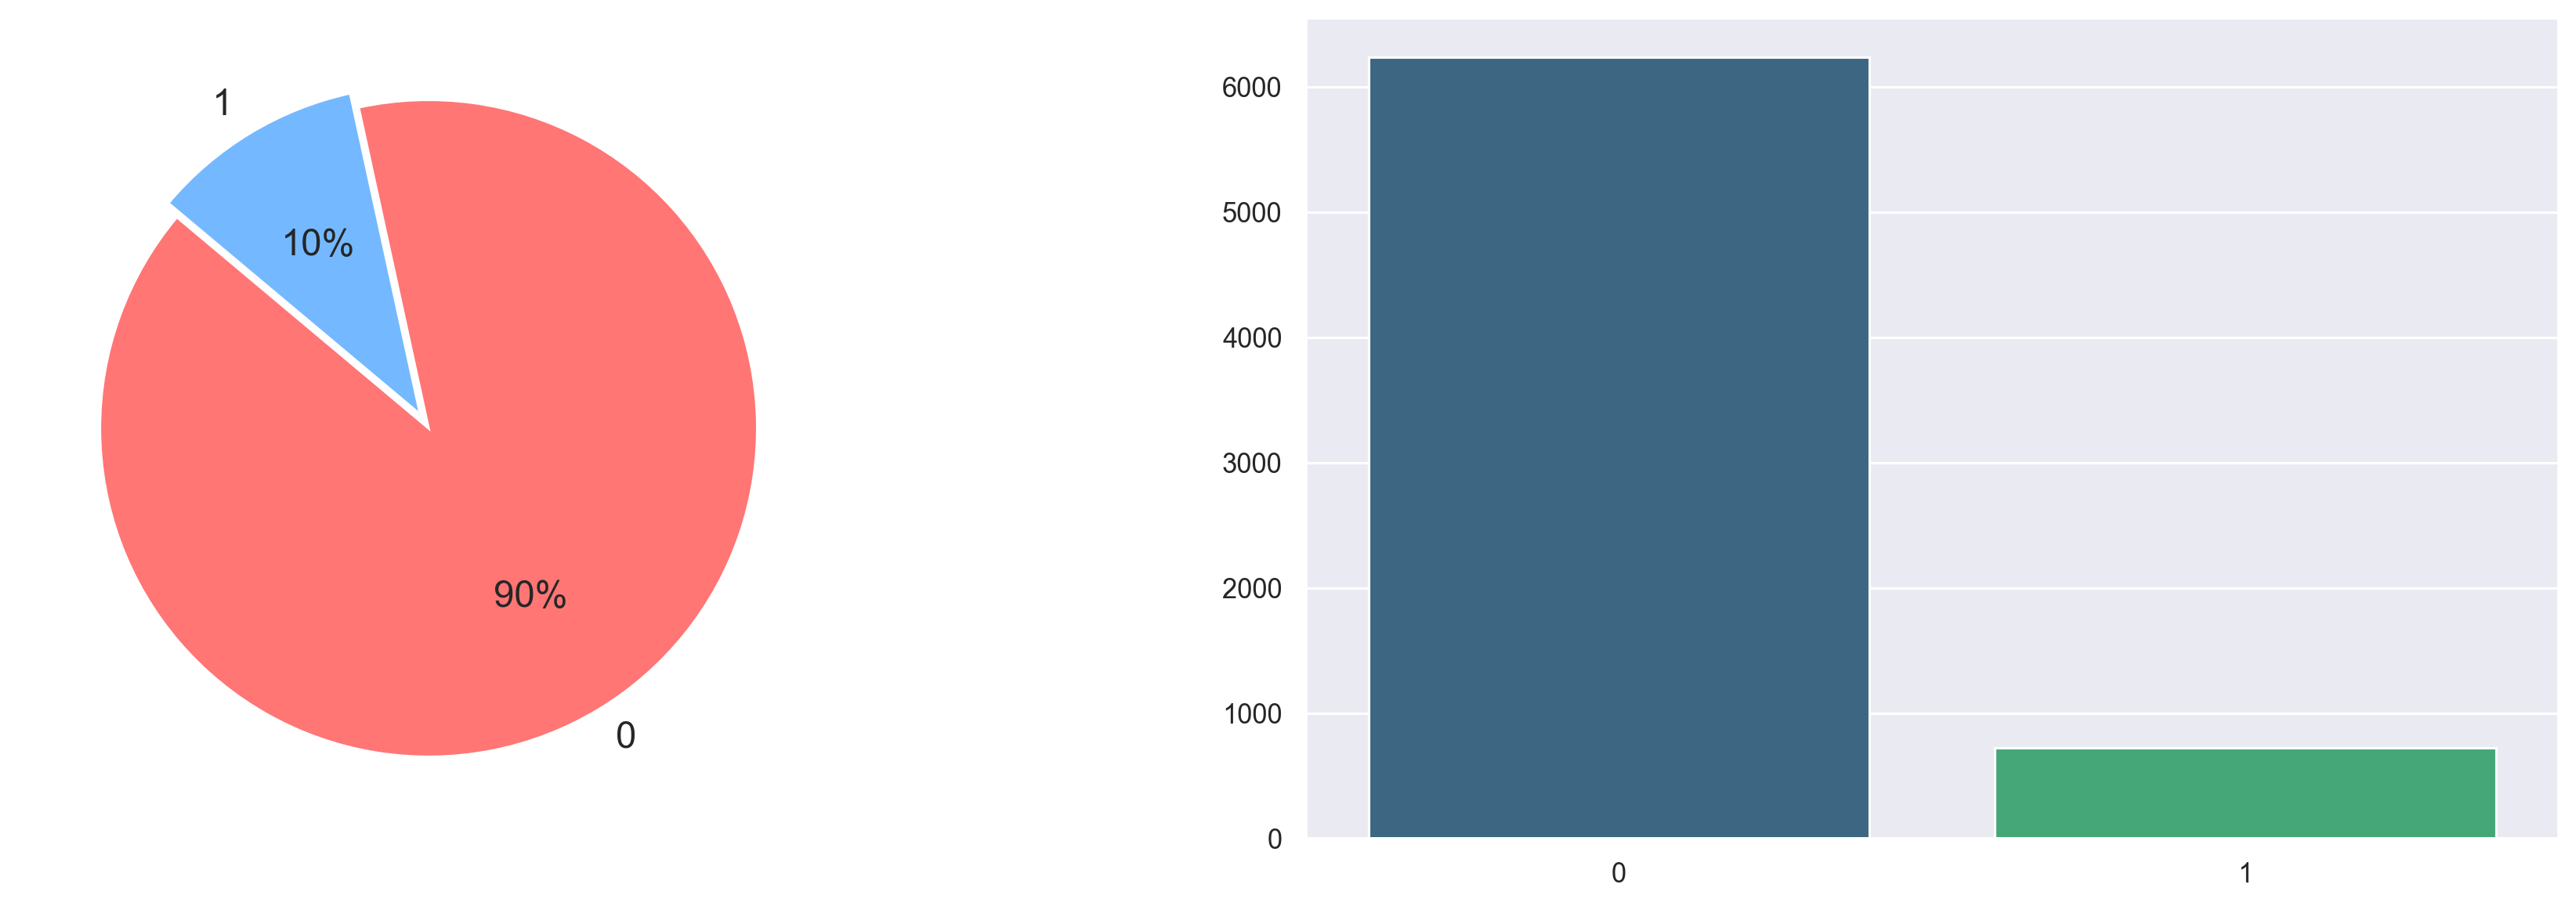

In [8]:

labels = [0,1]
sizes = [6240, 730]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x=labels,y = sizes, palette= 'viridis')

plt.show()

In [9]:

data['Total Words'] = data['text'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["text"].apply(count_total_words)

In [10]:

data.head()

,text,label,Total Words,Total Chars
0,oh my gosh,1.0,3,8
1,"trouble sleeping, confused mind, restless hear...",1.0,10,55
2,"All wrong, back off dear, forward doubt. Stay ...",1.0,14,65
3,I've shifted my focus to something else but I'...,1.0,11,51
4,"I'm restless and restless, it's been a month n...",1.0,14,59


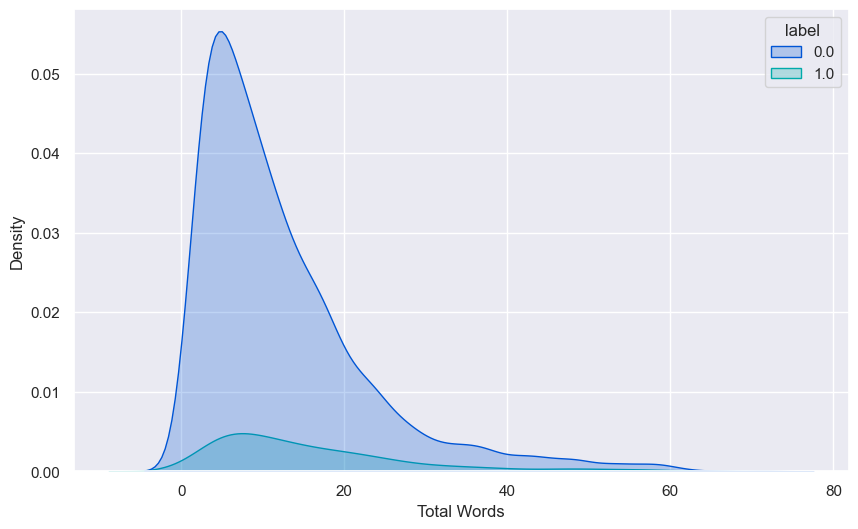

In [11]:

plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

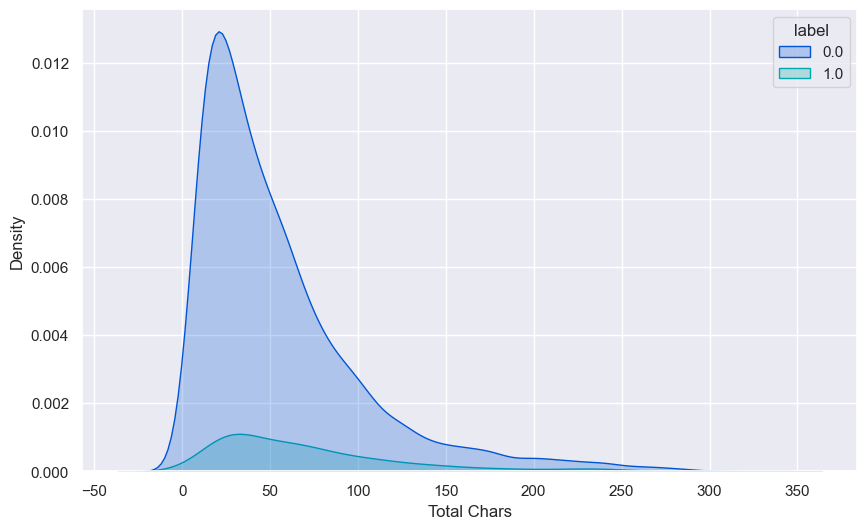

In [12]:

plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

In [13]:

data.head()

,text,label,Total Words,Total Chars
0,oh my gosh,1.0,3,8
1,"trouble sleeping, confused mind, restless hear...",1.0,10,55
2,"All wrong, back off dear, forward doubt. Stay ...",1.0,14,65
3,I've shifted my focus to something else but I'...,1.0,11,51
4,"I'm restless and restless, it's been a month n...",1.0,14,59


In [14]:

def convert_lowercase(text):
    text = text.lower()
    return text

data['text'] = data['text'].apply(convert_lowercase)

In [15]:

def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['text'] = data['text'].apply(remove_url)

In [16]:

exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['text'] = data['text'].apply(remove_punc)

In [17]:

def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['text'] = data['text'].apply(remove_stopwords)

In [18]:

def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text'] = data['text'].apply(perform_stemming)

In [19]:

data['Total Words After Transformation'] = data['text'].apply(lambda x: np.log(len(x.split())))

In [20]:

data.head()

,text,label,Total Words,Total Chars,Total Words After Transformation
0,oh gosh,1.0,3,8,0.693147
1,troubl sleep confus mind restless heart tune,1.0,10,55,1.945910
2,wrong back dear forward doubt stay restless re...,1.0,14,65,2.197225
3,ive shift focu someth els im still worri,1.0,11,51,2.079442
4,im restless restless month boy mean,1.0,14,59,1.791759


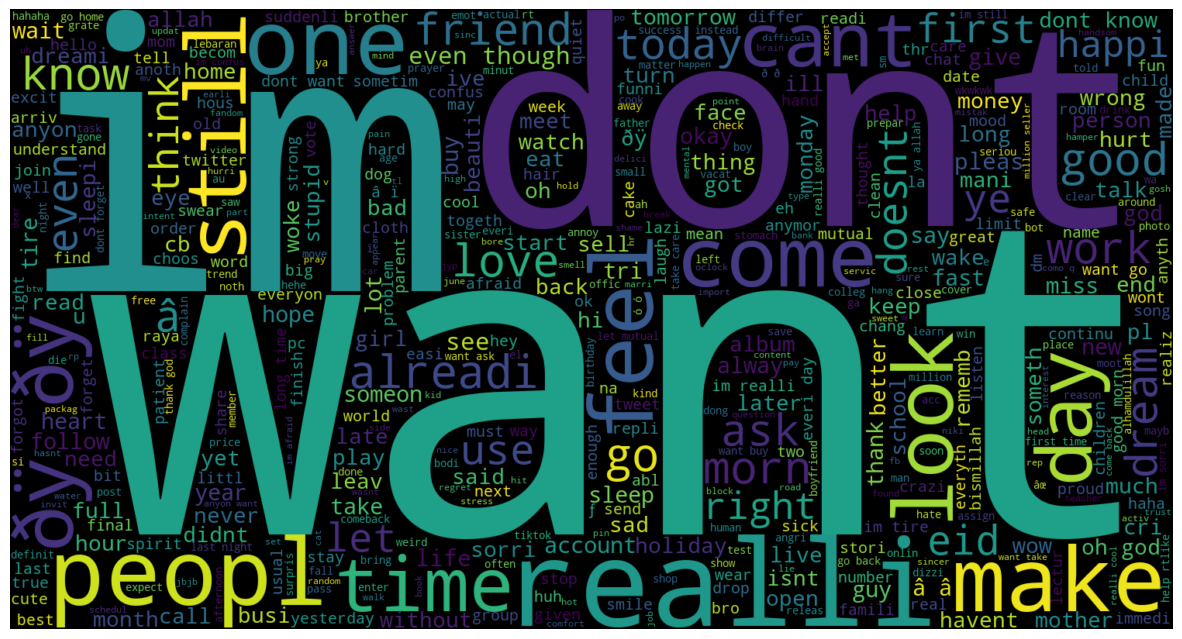

In [21]:

text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

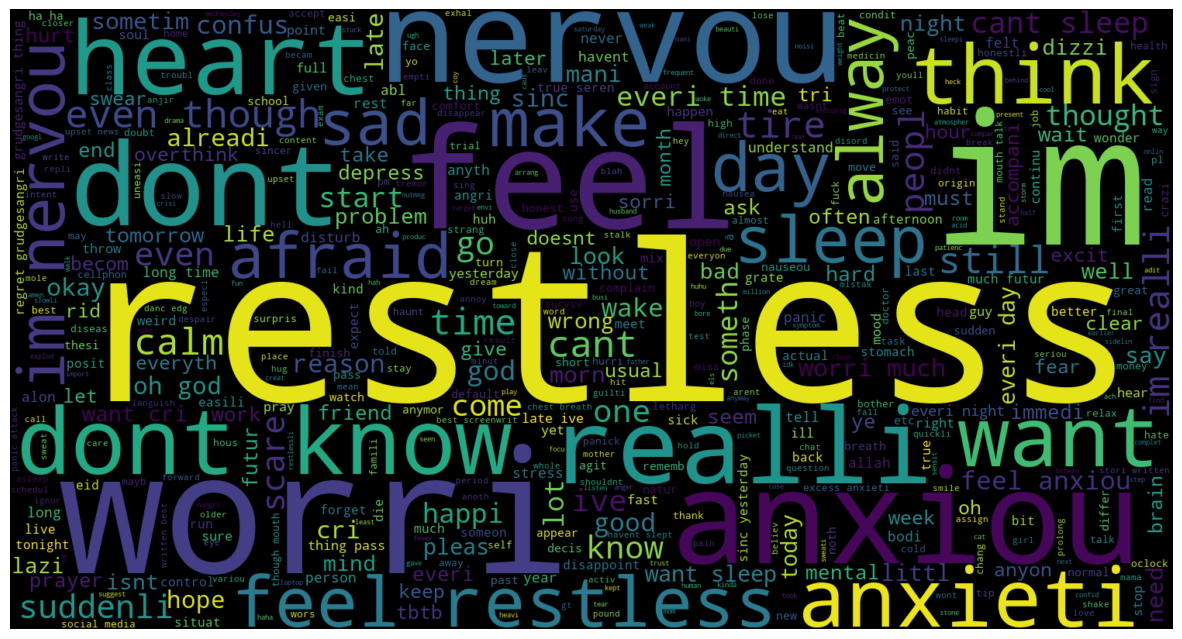

In [22]:

text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

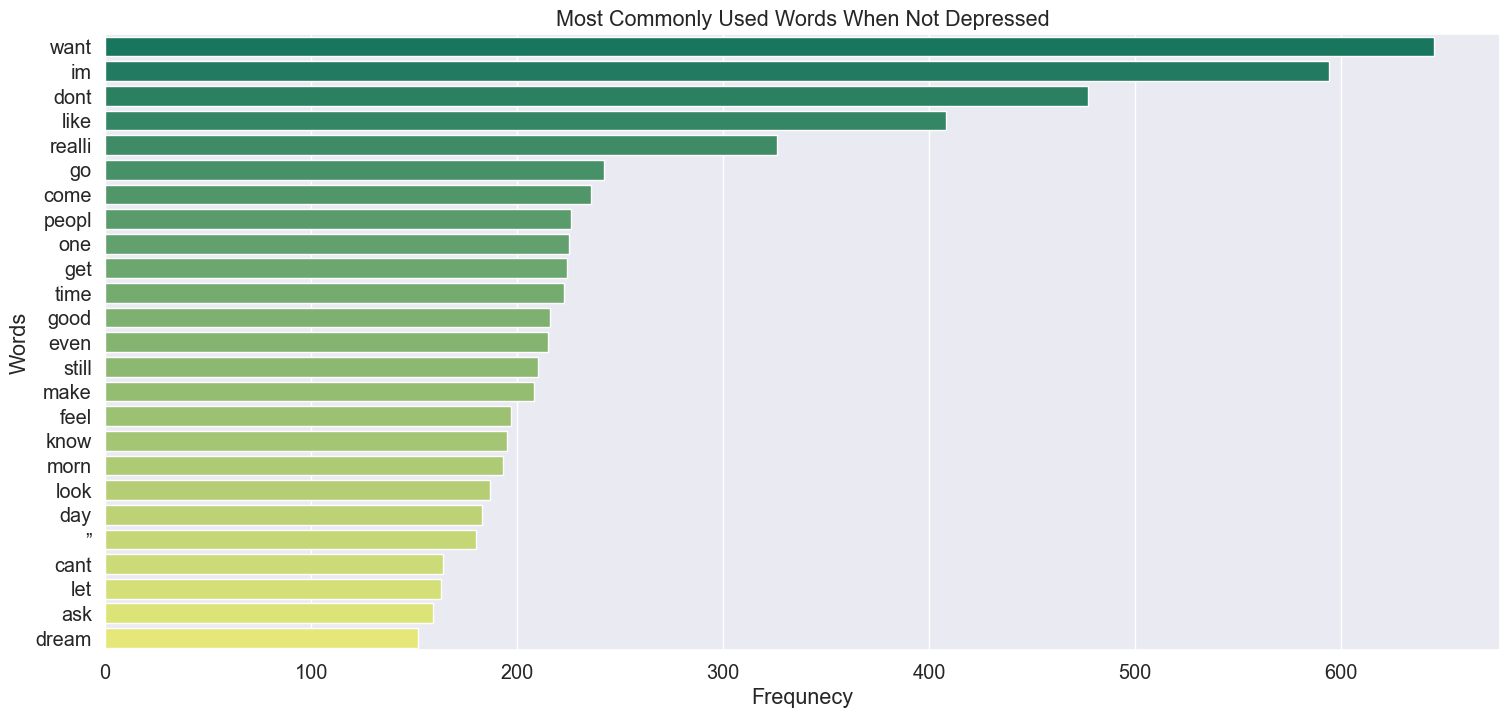

In [23]:

all_nodep_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_nodep_words.append(word)

df = pd.DataFrame(Counter(all_nodep_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words When Not Depressed")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

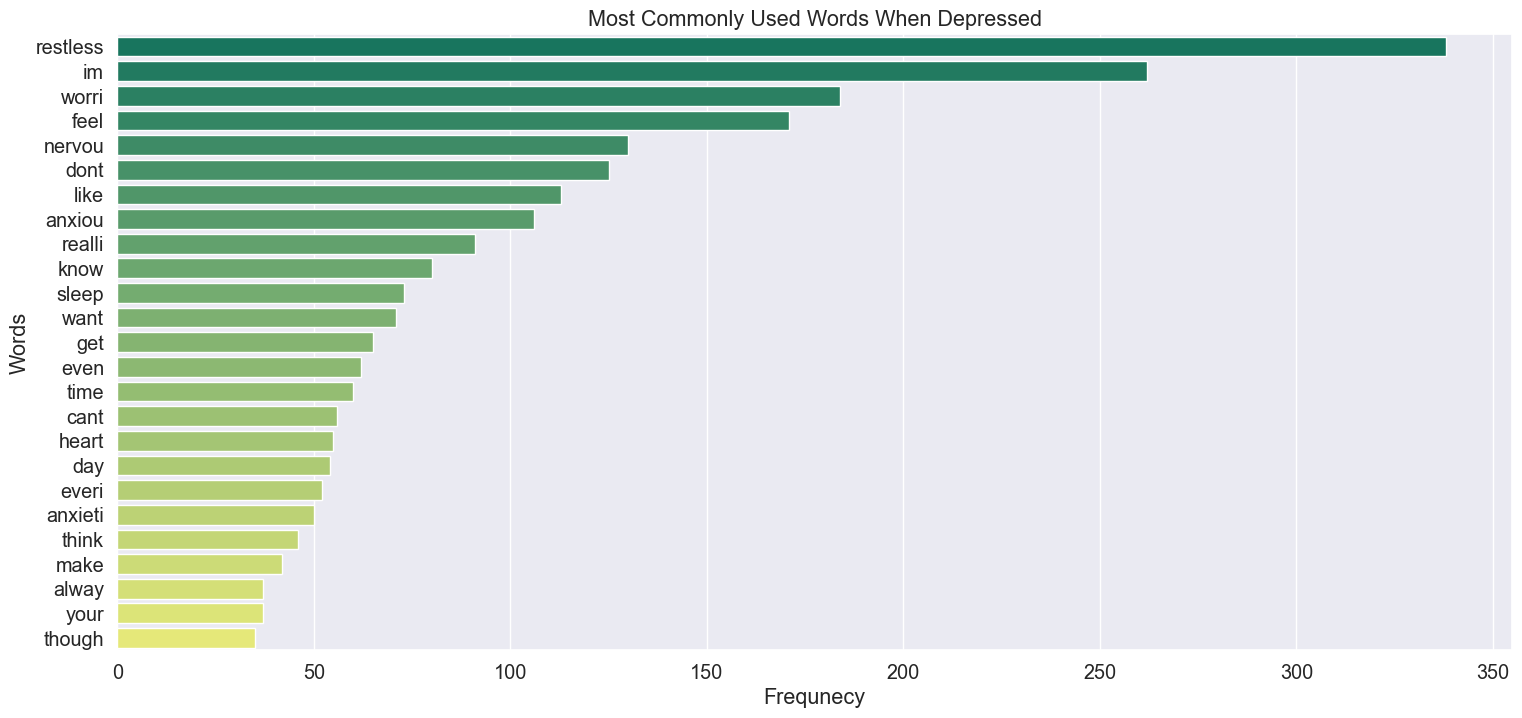

In [24]:

all_dep_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_dep_words.append(word)

df = pd.DataFrame(Counter(all_dep_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words When Depressed")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

In [36]:

X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 2, stratify = y)

In [37]:
X_train.shape

(5576,)

In [38]:

vectorizer= TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train).toarray()
X_test_transformed = vectorizer.transform(X_test).toarray()

In [39]:
X_test_transformed.shape

(1394, 8758)

In [40]:
X_train_transformed.shape

(5576, 8758)

In [41]:

rf = RandomForestClassifier(n_estimators= 300)
#train_model(rf)
rf.fit(X_train_transformed, y_train)
y_pred = rf.predict(X_test_transformed)
y_prob = rf.predict_proba(X_test_transformed)
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)

print(f'Accuracy of the model: {accuracy}')
print(f'Precision Score of the model: {precision}')
print(f'Recall Score of the model: {recall}')


Accuracy of the model: 0.989
Precision Score of the model: 0.985
Recall Score of the model: 0.911


In [42]:
import pickle


In [43]:
filename = 'anxiety_trained2.sav'
pickle.dump(rf,open(filename,'wb'))

In [46]:
import pickle
filename = 'vectorizer1.sav'
pickle.dump(vectorizer,open(filename,'wb'))

In [45]:
loaded_model = pickle.load(open('anxiety_trained2.sav','rb'))

In [58]:
import re
import pandas as pd


data = {'text': ['trouble sleeping, confused mind, restless heart. All out of tune']}
df = pd.DataFrame(data)


df['Total Words'] = df['text'].apply(lambda x: len(re.findall(r'\w+', x)))


df['Total Chars'] = df['text'].apply(lambda x: sum(len(word) for word in x.split()))

print(df)

                                                text  Total Words  Total Chars
0  trouble sleeping, confused mind, restless hear...           10           55


In [59]:
def convert_lowercase(text):
    text = text.lower()
    return text

df['text'] = df['text'].apply(convert_lowercase)

In [60]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

df['text'] = df['text'].apply(remove_url)

In [61]:
import string
exclude = string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))
df['text'] = df['text'].apply(remove_punc)

In [62]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

df['text'] = df['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [63]:
from nltk.stem import PorterStemmer
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

df['text'] = df['text'].apply(perform_stemming)

In [64]:
import numpy as np
df['Total Words After Transformation'] = df['text'].apply(lambda x: np.log(len(x.split())))

In [65]:
vec= pickle.load(open('vectorizer1.sav','rb'))

In [66]:
X_test_array = vec.transform(df).toarray()

In [67]:
prediction=loaded_model.predict(X_test_array)

In [68]:
print(prediction)

[0. 0. 0. 0.]
